In [1]:
from setup_libs import *
%matplotlib inline


# Compositions, Ensembles, RandomForest

# 1. Bootstrap

### Задача
Пусть преподаватель на паре предложил угадать студентам свой возраст. Но на пары, конечно же, ходит не так много человек, как хотелось бы, поэтому он получил 10 ответов: 
$$37, 43, 38, 36, 17, 40, 40, 45, 41, 84$$ 

Теперь посчитаем среднее и его [стандартную ошибку](https://ru.wikipedia.org/wiki/%D0%A1%D1%82%D0%B0%D0%BD%D0%B4%D0%B0%D1%80%D1%82%D0%BD%D0%B0%D1%8F_%D0%BE%D1%88%D0%B8%D0%B1%D0%BA%D0%B0), т.е. корень из дисперсии среднего значения выборки.

In [2]:
from scipy.stats import sem
x = np.array([37,43,38,36,17,40,40,45,41,84])
x.mean(), sem(x)

(np.float64(42.1), np.float64(5.25452186216786))

В такой маленькой выборке среднее и стандартная ошибка будут очень сильно реагировать две очень разные оценки: $(17, 84)$. Можем ли мы как-то решить данную проблему?

На самом деле да: давайте сделаем предположение, что данное эмпирическое распределение верно и для 1000 чел. Тогда можно воспользоваться алгоритмом **бутстрапа**.

----

Немного обобщим задачу:

Пусть имеется выборка $X$ размера $N$, где $N$ крайне мало. И мы хотим посчитать некоторую **статистику** на ней.

**Статистика** — измеримая числовая функция от выборки, не зависящая от неизвестных параметров распределения элементов выборки. "Не зависит от неизвестных параметров..." можно понимать как то, что мы можем вычислить эту функцию, имея только нашу выборку, но не знания об истинном среднем случайной величины, например. 

Примеры статистик: выборочное среднее, медиана, дисперсия и.т.д.


### Алгоритм Bootstrap 
* Равномерно возьмем из выборки $N$ объектов **с возвращением**. То есть мы хотим сгенерировать подвыборку, в которой могут повторятся элементы из исходной выборки. 

* Обозначим новую выборку через $X_1$. Повторяя процедуру $B$ раз, сгенерируем $B$ подвыборок $X_1, \dots, X_B$. 

* Посчитаем статистику T от каждой выборки $(T(X_1), \ldots, T(X_n))$

* Найдем итоговую статистику $T(X) = \frac{1}{B}\sum^{B}_{i}T(X_i)$


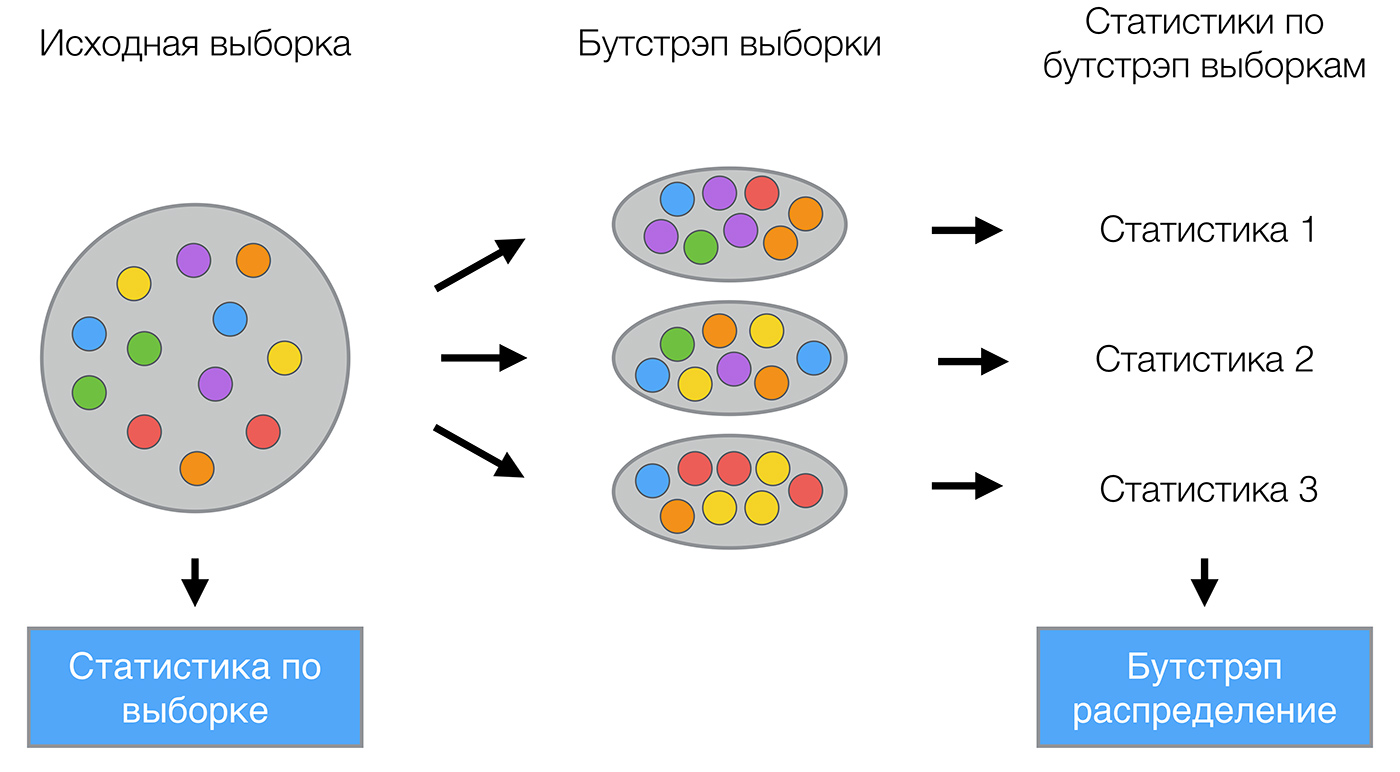

In [3]:
Image('images/bootstrap.jpg', width=500)

## Пример 

C помощью алгоритма сгенерируем 10 выборок

```
 [36 43 36 40 41 84 40 40 37 84]
 [37 37 41 43 17 45 36 37 84 45]
 [40 45 41 41 84 17 38 17 84 36]
 [43 45 40 36 37 38 17 37 41 45]
 [40 38 84 36 40 84 45 17 40 43]
 [41 40 84 43 17 36 40 37 37 38]
 [17 40 41 40 40 38 45 43 84 84]
 [43 38 45 36 17 38 41 37 41 84]
 [40 40 36 36 38 36 40 38 41 38]
 [43 41 40 45 45 40 36 36 36 36]
```
У каждой выборки посчитаем среднее и стандартную ошибки, а потом усредним их

mean=42.78, se_mean=4.673017491077988


Таким образом мы **уменьшили** $SE$ (standart error) и более точно можно определить мат. ожидание.

На самом деле 10 выборок - это очень мало, и значения среднего и стандартной ошибки будут часто плавать. Но именно благодаря тому, что мы можем увеличивать количество выборок $B$ - мы можем уменьшить доверительный интервал и увидеть точное значение. Например взяв миллион выборок.

---

## Дополнительно

Вообще бутстрап дает возможность работать не только со средним, но и с любой статистикой. Более того, бутстрап порой единственный способ посчитать доверительные интервалы для нелинейных статистик например $ln\overline{X}$ (логарифм среднего), потому что стандартная ошибка данной статистики не считается аналитически. 

Доказательство корректности алгоритма Бутстрап проводится через Усиленный Закон Больших Чисел. Для всех интересующихся [ссылка](http://www.stat.cmu.edu/~larry/=sml/Boot.pdf).

# 2.Bias-Variance decomposition.

Альтернативное изложение с бОльшим количеством картинок есть [тут](https://alexanderdyakonov.wordpress.com/2018/04/25/%D1%81%D0%BC%D0%B5%D1%89%D0%B5%D0%BD%D0%B8%D0%B5-bias-%D0%B8-%D1%80%D0%B0%D0%B7%D0%B1%D1%80%D0%BE%D1%81-variance-%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8-%D0%B0%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82/)

Рассмотрим задачу **регрессии** 

Введем обозначения:
* $X$ - множество объектов (векторов)
* $f(x)$ - реальная функция мира, которую хотим предсказать
* $y: y_i = f(x_i) + \varepsilon_i ~~~(\varepsilon_i \in \mathcal{N}(0,\sigma))$ - множество измеренных значений (**target**) с некоррелированным шумом
* $a(x)$ - наш регрессор, который подбираем
* $L(x,y) = (a(x) - y)^2$ - функция потерь (MSE)

В кросс-валидации мы смотрели на `качество` модели, как на возможность обучиться на различных данных и давать одинаково хороший результат. Давайте рассматривать регрессор $a(x)$ как случайную величину, зависящую от выборки $(X_{train}, y_{train})$.

Мы хотим найти некий *идеальный* регрессор $a_{(X, y)}(x)$, который **в среднем относительно обучающей выборки** имеет наименьшую ошибку на **одном объекте (x,y)**. 

$$Error = \mathbb{E}_{(X_{train}, y_{train})}(a_{(X_{train}, y_{train})}(x)-y)^2$$

$(X_{train}, y_{train})$ - имеют какую-то **абстрактную** вероятностную меру в своем пространстве $\mathbb{X}$, поэтому можем взять мат. ожидание. $y=f(x) + \varepsilon$, $\varepsilon \sim \mathcal{N}(0, \sigma^2)$ аналогично тренировочной выборке

Для упрощения дальнейшей нотации буду писать просто мат. ожидание по $a$.

$$Error = \mathbb{E}_{a}(a(x)-y)^2 \rightarrow \min$$



Данное выражение можно разложить так (пример и пояснения [отсюда](https://alexanderdyakonov.wordpress.com/2018/04/25/%D1%81%D0%BC%D0%B5%D1%89%D0%B5%D0%BD%D0%B8%D0%B5-bias-%D0%B8-%D1%80%D0%B0%D0%B7%D0%B1%D1%80%D0%BE%D1%81-variance-%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8-%D0%B0%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82/))

$$
\begin{gathered}\mathrm{E}(y-a)^2=\mathrm{E}\left(y^2+a^2-2 y a\right)= \\ =\mathrm{E} y^2-(\mathrm{E} y)^2+(\mathrm{E} y)^2+\mathrm{E} a^2-(\mathrm{E} a)^2+(\mathrm{E} a)^2-2 y \mathrm{E} a= \\ =\mathrm{D} y+\mathrm{D} a+(\mathrm{E} y)^2+(\mathrm{E} a)^2-2 \mathrm{E} y a= \\ =\mathrm{D} y+\mathrm{D} a+f^2+(\mathrm{E} a)^2-2 f \mathrm{E} a= \\ =\mathrm{D} y+\mathrm{D} a+(\mathrm{E}(f-a))^2 \equiv \sigma^2+\operatorname{variance}(a)+\operatorname{bias}^2(f, a)\end{gathered}
$$

Еще раз, тут важно понимать, как берутся матожидания    в приведённых выше формулах. Мы считаем, что обучающая выборка выбирается случайно из некоторого распределения, настроенный алгоритм тоже случаен, поскольку зависит от выборки, настройка алгоритма также может быть стохастической. Таким образом, матожидание берётся по всем данным (обучающим выборкам) и настройкам алгоритма, а сами формулы записываются в конкретном примере из выборки. 

1. **Смещение (Bias)** - отклонение мат. ожидания ответа алгоритма от **реальной** функции.
2. **Разброс (Variance)** - разброс, среди возможных алгоритмов $a(\cdot)$, обученных на разных тренировочных выборках.
3. **Шум (Noise)** - шум из-за неточных данных.

Аналогично все можно расписать в терминах для нескольких объектов:

$$Error = \frac{1}{N}\sum_{x,y \in (X_{test}, y_{test})}\mathbb{E}_{a}(a(x)-y)^2$$

$$\frac{1}{N}\sum_{x,y \in (X_{test}, y_{test})}\mathbb{E}_{a}(a(x)-y)^2 = 
\frac{1}{N}\sum_{x,y \in (X_{test}, y_{test})}\underbrace{\Big(\mathbb{E}_{a}[a(x)] - f(x)\Big)^2}_{Bias} + 
\frac{1}{N}\sum_{x,y \in (X_{test}, y_{test})}\underbrace{\mathbb{D}_{a}a(x)}_{Variance} + 
\underbrace{\sigma^2}_{Noise}$$

На самом деле все эти усреднения - просто мат. ожидания по всему множеству $\mathbb{X}$, ведь теоретически мы целимся в то, чтобы наш алгоритм работал не только на тестовой выборке.

$$Error = \mathbb{E}_{(\mathbb{X},Y)}\mathbb{E}_{a}(a(x)-y)^2$$

$$\mathbb{E}_{(\mathbb{X},Y)}\mathbb{E}_{a}(a(x)-y)^2 = 
\mathbb{E}_{(\mathbb{X},Y)}\underbrace{\Big(\mathbb{E}_{a}[a(x)] - f(x)\Big)^2}_{Bias} + 
\mathbb{E}_{(\mathbb{X},Y)}\underbrace{\mathbb{D}_{a}a(x)}_{Variance} + 
\underbrace{\sigma^2}_{Noise}$$

## И зачем нам это?

Пусть мы обучаем линейную регрессию: в одном случае полином 1 степени, в другой 10-ой. 

В случае полинома **1 степени** мы обучаясь на разных тренировочных выборках мы будем получать примерно **одинаковый** результат. Однако полученные функции будут достаточно **сильно** отличаться от искомой функции **в точках**, на которых мы обучаемся. 

Тогда по нашей формуле мы получаем **большой Bias** и **малый Variance**

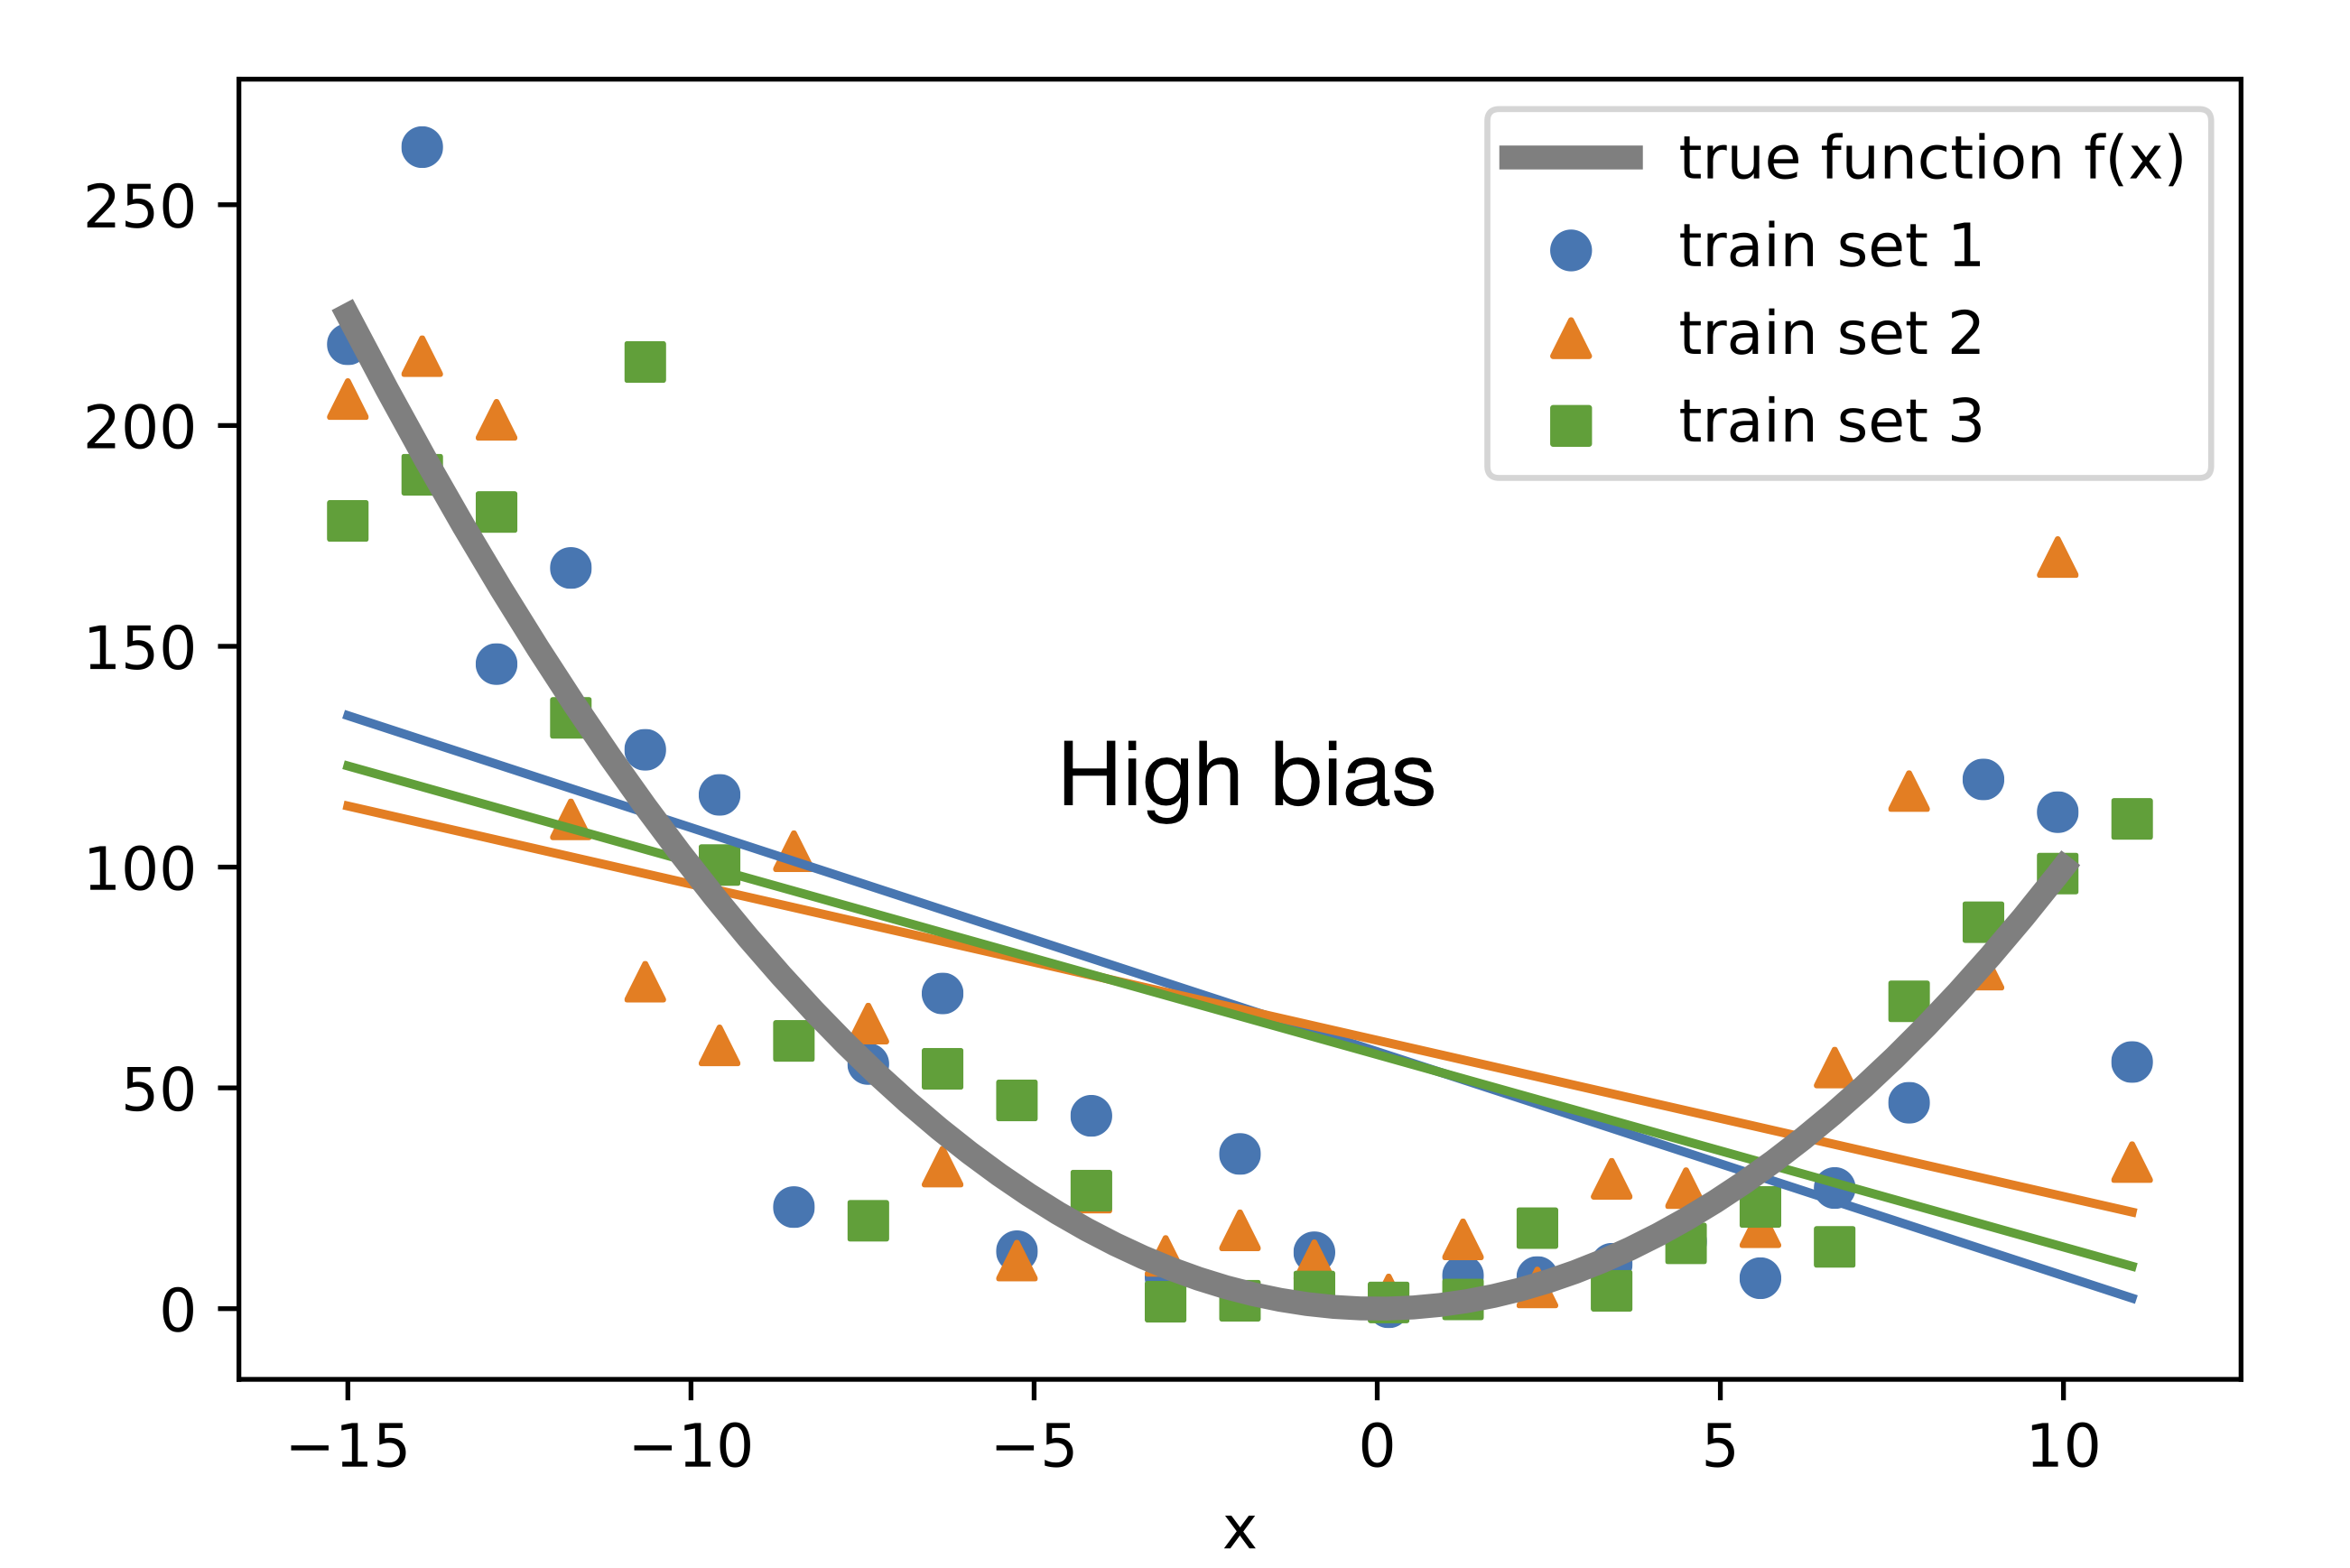

In [4]:
Image('images/bias.png', width=700)

В случае полинома **10 степени** мы обучаясь на разных тренировочных выборках мы будем получать сильно **отличающиеся** результаты. Однако полученные функции будут попадать **ровно в точки** искомой функции, на которых мы обучаемся. 

Тогда по нашей формуле мы получаем **малый Bias** и **большой Variance**

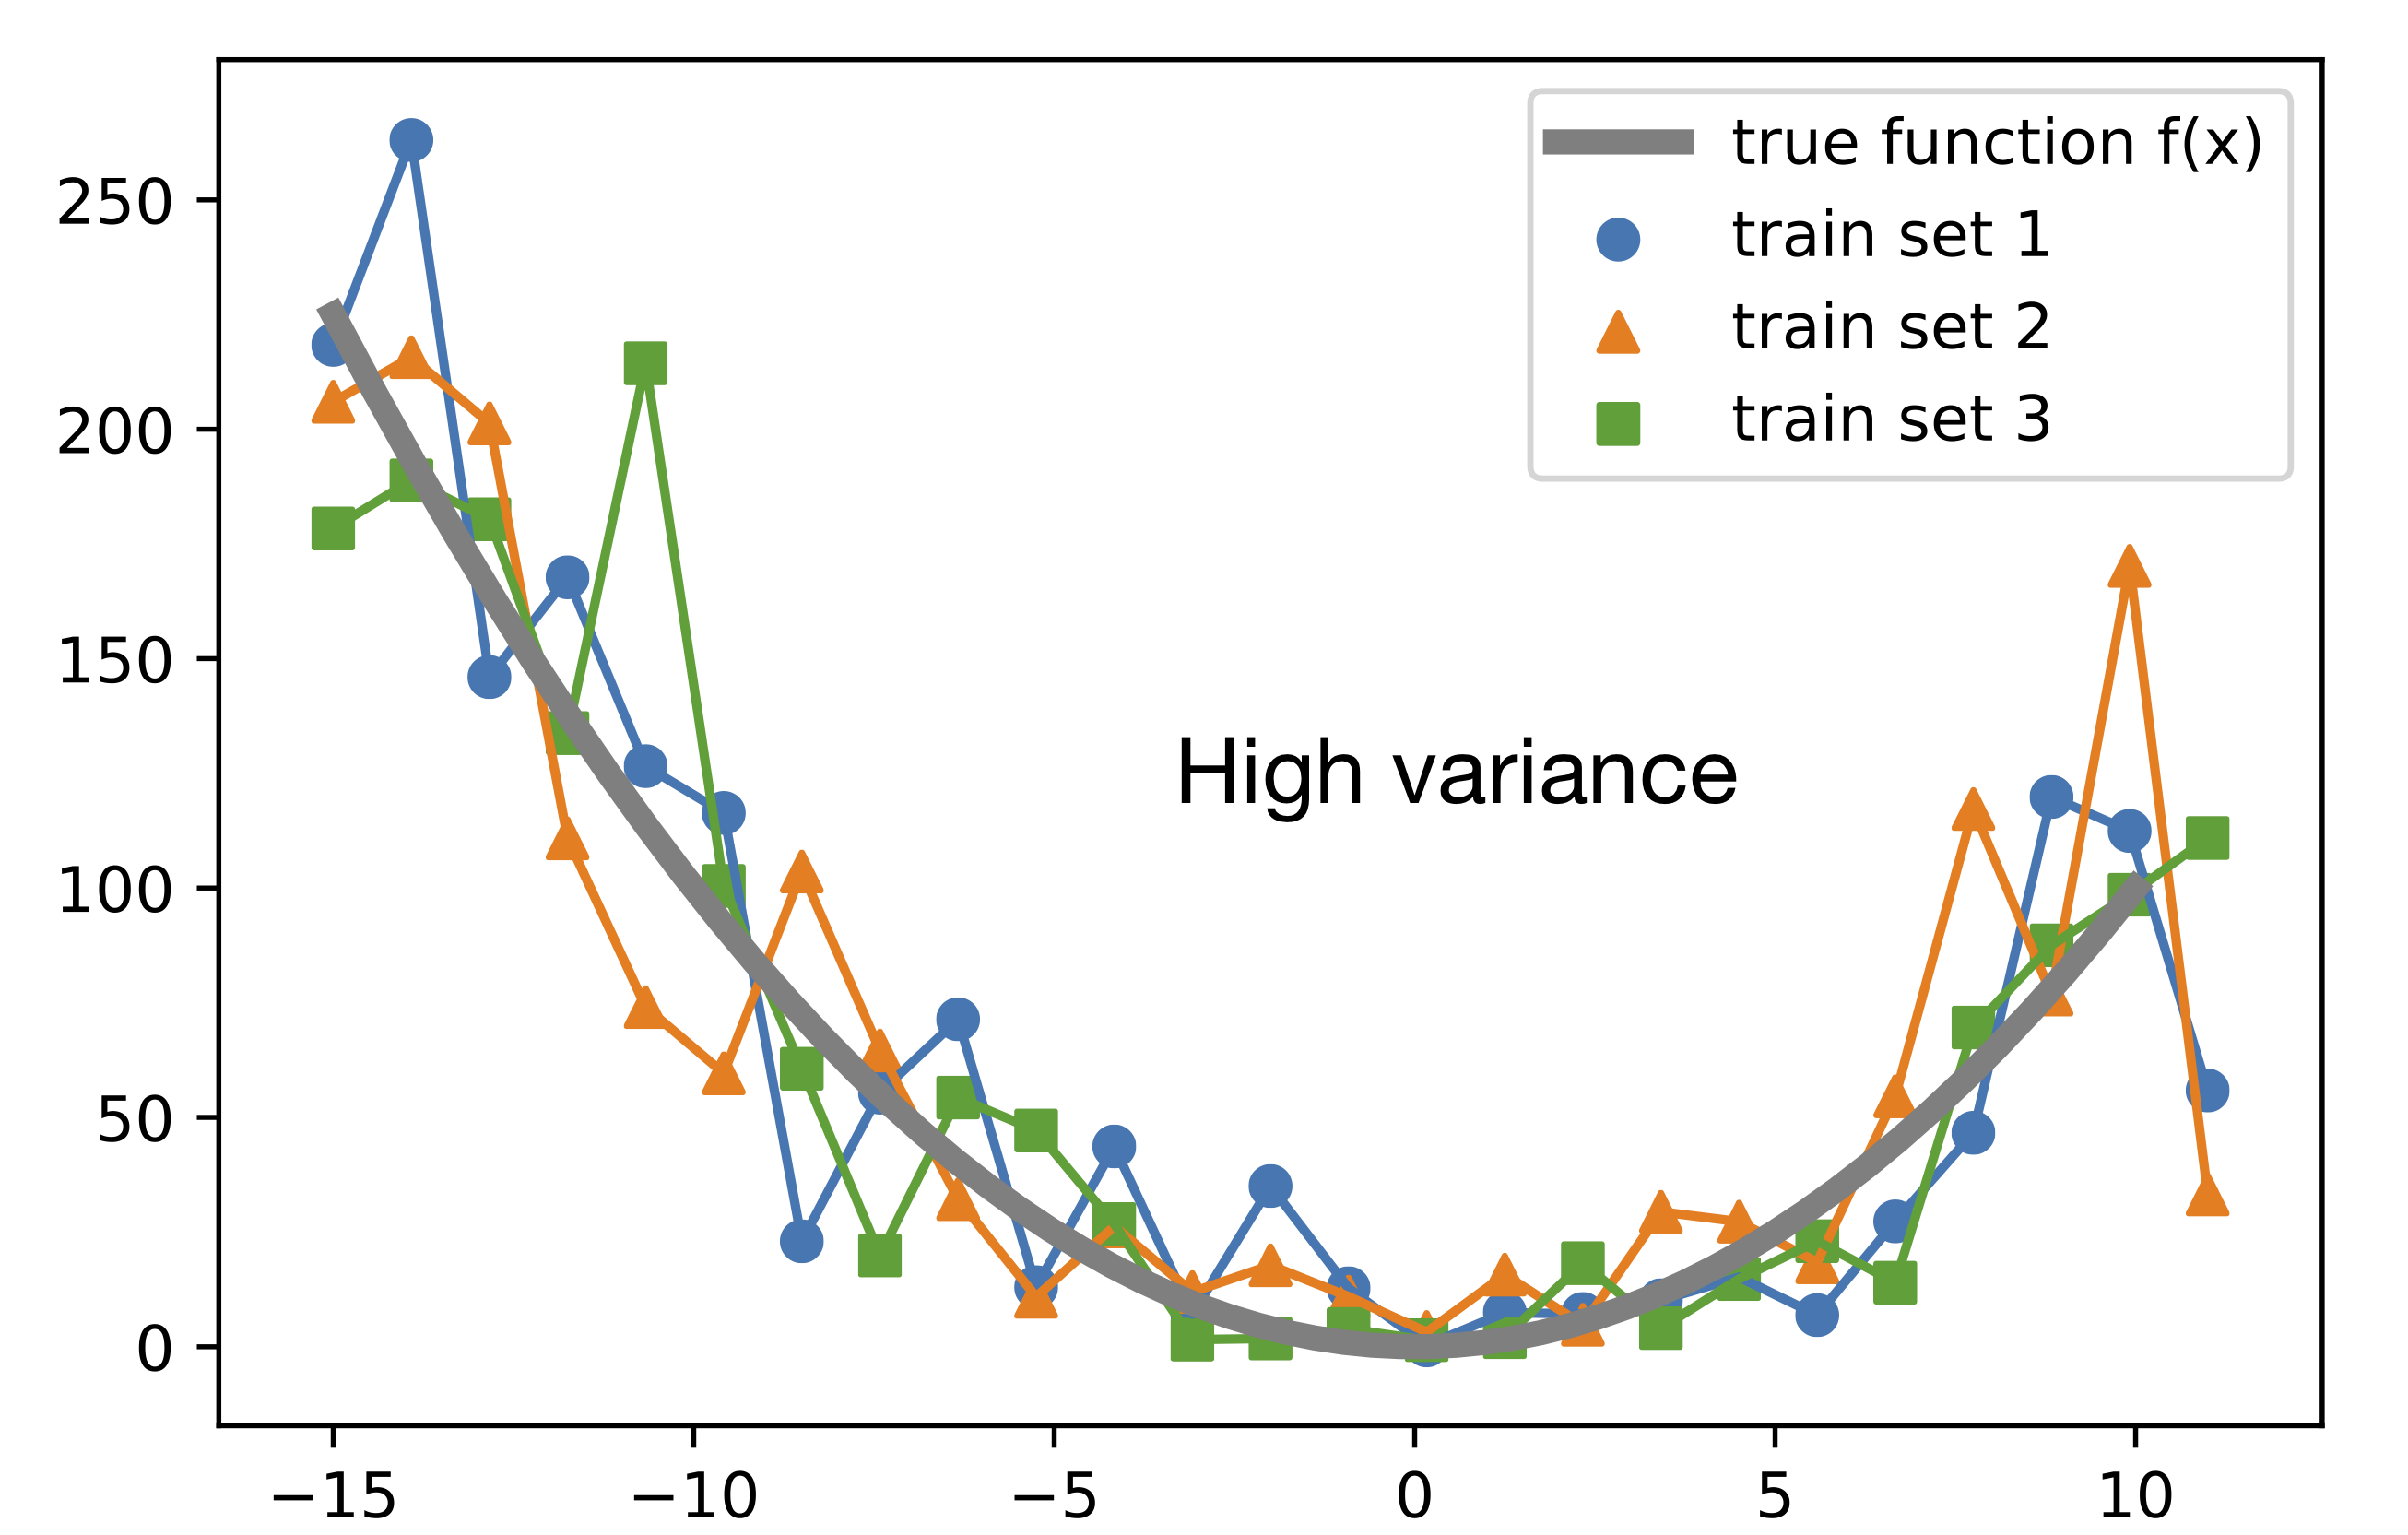

In [5]:
Image('images/variance.png', width=700)

### На самом деле мы получили чуть менее эвристическое обоснование переобучения и недообучения

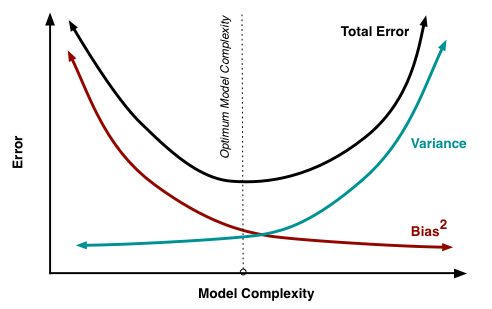

In [6]:
Image('images/biasvariance.png', width=700)

Вот еще одна наглядная картинка для рефлексии

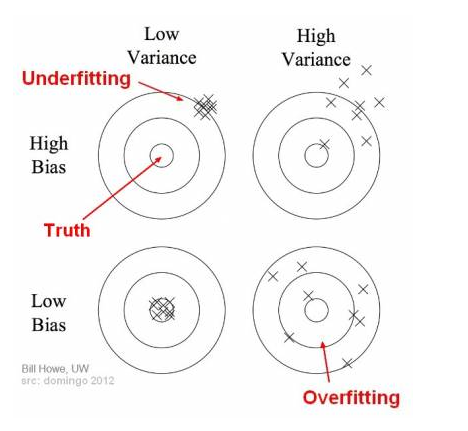

In [7]:
Image('images/bullseye.png', width=700)

## 2.1 А что там для классификации?

Вспомним какой **Error** у классификации:
$$L(x)=\begin{cases}0 ~~~\text{если правильно определили класс} \\ 1~~~\textrm{в другом случае}\end{cases}$$

В качестве результата среди всех алгоритмов мы выбираем самое вероятное решение: **моду**
$$\mathbb{E}_aa(x) = argmax_{class}P(x \in class)$$

**Bias** в этом случае отклонение от моды

$$Bias(a)=\begin{cases}0 ~~~y = E_aa(x) \\ 1~~~y \neq E_aa(x)\end{cases}$$

**Variance**

$$Var(a) = \mathcal{E}[a^2] - \mathcal{E}[a]^2 $$
$$E\left(a\right)= 1 \cdot p + 0 \cdot (1-p) = p;$$ 
$$ E\left(a^2\right)=1^2 \cdot p+0^2 \cdot(1-p)=p$$
$$Var(a) = p - p^2 = p(1-p) = P(y = E_aa(x))P(y \neq E_aa(x))$$

# 3. Bagging (bootsrap aggregating)

Вот теперь непосредственно можем перейти к теме занятия.

Давайте объединим предыдущие 2 идеи:
* Набутстрапим несколько псевдовыборок ($X_1, \ldots, X_B$) из нашей выборки $X$.
* Обучим на каждой псевдовыборке один и тот же алгоритм $a_1(\cdot), \ldots a_B(\cdot)$.
* А результат будем получать как среднее из выходов обученных моделей $$a(x) = \frac{1}{B}\sum_{i=1}^{B}a_i(x)$$

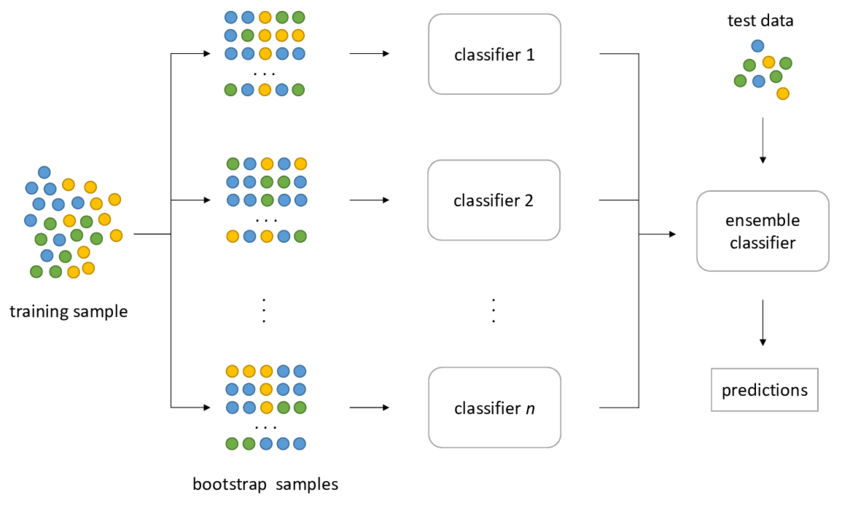

In [8]:
Image('images/bagging.png', width=500)

In [9]:
X, y = make_regression(n_samples=100, n_features=4, 
                       n_informative=2, n_targets=1,
                       random_state=0, shuffle=False)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=123,
                                                    shuffle=True)

dtr = DTR(max_depth=3).fit(X_train, y_train)

br = BaggingRegressor(estimator=DTR(max_depth=3), #выбрали тип алгоритма a(x)
                        n_estimators=30, #количество регрессоров B 
                        random_state=0).fit(X_train, y_train)


print('DTR Loss:{} \nBagging Loss:{}'.format(MSE(dtr.predict(X_test), y_test),
                                             MSE(br.predict(X_test), y_test)))

DTR Loss:401.21273308735243 
Bagging Loss:150.0127291660213


Как можем заметить Loss у бэггинга заметно ниже, хотя мы использовали и в том и другом случае деревья одинаковой глубины

## Почему Лосс у Бэггинга меньше?

Посмотрим на  **Bias**
$$(\mathbb{E}_{a}[a(x)] - f(x))^2 = \Big(f(x) - \mathbb{E}_{a}\frac{1}{B}\sum_{b=1}^{B}a_b(x)\Big)^2 = \Big(f(x) - \mathbb{E}_{a}a_1(x)\Big)^2$$ 

По линейности мат. ожидания получаем, что **Bias у бэггинга такой же, как и у одной модели**.

Посмотрим на  **Variance**
$$\mathbb{D}_{a}a(x)= \mathbb{E}_{a}(a(x) - \mathbb{E}_{a}a(x))^2 = 
\mathbb{E}_{a}\Big[\frac{1}{B}\sum_{b=1}^{B}a_b(x)-\mathbb{E}_{a}\frac{1}{B}\sum_{b=1}^{B}a_b(x)\Big]^2=\mathbb{E}_{a}\Big[\frac{1}{B}\sum_{b=1}^{B}\Big(a_b(x)-\mathbb{E}_{a}a_b(x)\Big)\Big]^2 = $$

Тут выделим отдельно полные квадраты

$$=\frac{1}{B^2}\mathbb{E}_{a}\Big[\sum_{b=1}^{B}\Big(a_b(x)-\mathbb{E}_{a}a_b(x)\Big)^2 + \sum_{b, c=1, b \neq c}^{B}\Big(a_b(x)-\mathbb{E}_{a}a_b(x)\Big)\Big(a_c(x)-\mathbb{E}_{a}a_c(x)\Big)\Big] = $$

$$=\frac{1}{B^2}\Big[\sum_{b=1}^{B}\mathbb{E}_{a}\Big(a_b(x)-\mathbb{E}_{a}a_b(x)\Big)^2\Big] + \frac{1}{B^2}\sum_{b, c=1, b \neq c}^{B}\mathbb{E}_{a}\Big[\Big(a_b(x)-\mathbb{E}_{a}a_b(x)\Big)\Big(a_c(x)-\mathbb{E}_{a}a_c(x)\Big)\Big] \leq $$

$$\leq \frac{1}{B}\max_{b \in B} \mathbb{D}_{a}a_b(x) + \frac{1}{B^2}\sum_{b, c=1, b \neq c}^B cov(a_b(x), a_c(x)) $$
$$\leq\frac{1}{B}\max_{b \in B} \mathbb{D}_{a}a_b(x) + \frac{(B-1)^2}{B^2}\max_{b,c \in B, b\neq c}cov(a_b(x), a_c(x)) $$


**Получается**: пока деревья слабо коррелированы - мы можем сильно уменьшить **Variance**. Однако с какого-то момента деревьев станет слишком много, значит среди них будут попадаться сильно скоррелированные. Это и остановит уменьшение *Variance*.

## Bagging не меняет Bias, но позволяет уменьшить Variance за счет уменьшения дисперсии при слабо коррелированных деревьях.

В библиотеке `scikit-learn` есть реализация `BaggingRegressor` и `BaggingClassifier`, которая позволяет использовать большинство других алгоритмов "внутри". [Полезный пример](http://scikit-learn.org/stable/auto_examples/ensemble/plot_bias_variance.html#sphx-glr-auto-examples-ensemble-plot-bias-variance-py).


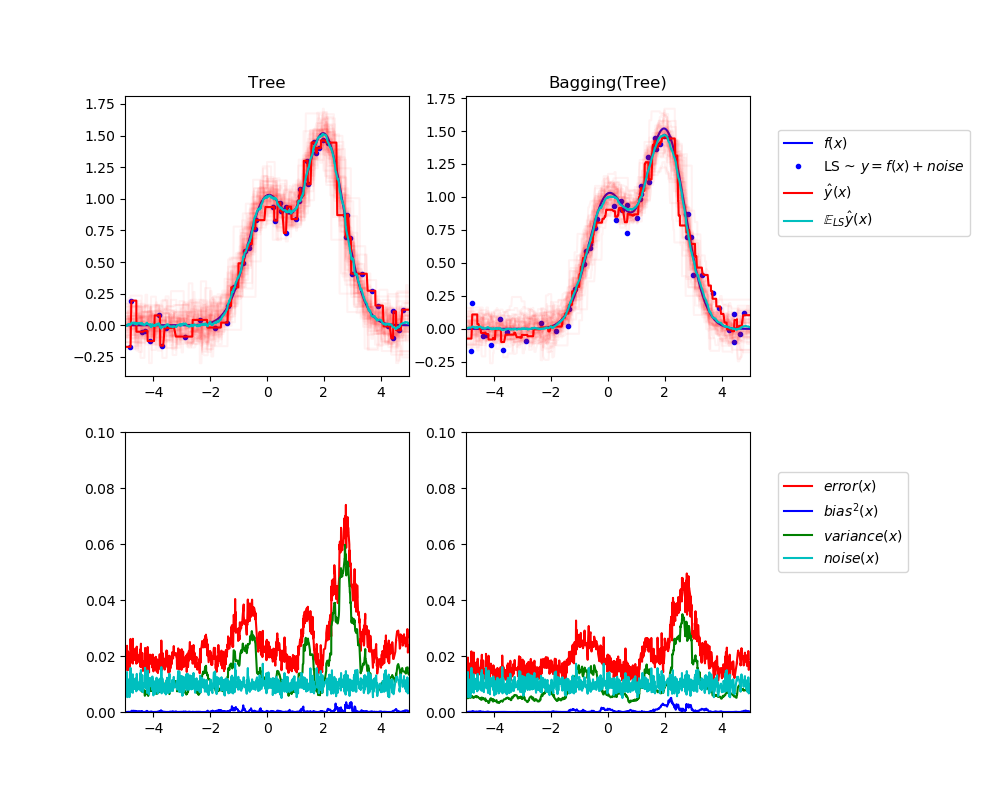

In [10]:
Image('images/bagging_exam.png', width=1000)

## А что с классификацией?

Пусть у нас есть ансамбль классификаторов. Как выбрать предсказание для объекта?
* Возвращаем вероятности каждого класса для объекта в каждом классификаторе
* Усредняем вероятность каждого класса по классификаторам
* Присваиваем тот класс, который получил наибольшую среднюю вероятность по классификаторам

Пример (4 класса (`1,2,3,4`), 2 классификатора):
* $P{(a_1(x))} = {0.2,0.3,0.4,0.1}$
* $P{(a_2(x))} = {0.2,0.3,0.1,0.4}$
* $P{(a(x))} = {0.2,0.3,0.25,0.25}$
* $a(x) = 2$, $P(a(x)=2) = 0.3$

## 3.1 Out-of bag Error

Пусть в выборке $\ell$ объектов. На каждом шаге все объекты попадают в подвыборку с возвращением равновероятно, т.е отдельный объект — с вероятностью  $\frac{1}{\ell}.$ Вероятность того, что объект НЕ попадет в подвыборку (т.е. его не взяли $\ell$ раз): $(1 - \frac{1}{\ell})^\ell$. При $\ell \rightarrow +\infty$ получаем один из "замечательных" пределов $\frac{1}{e}$. Тогда вероятность попадания конкретного объекта в подвыборку $\approx  1 - \frac{1}{e} \approx 63\%$.


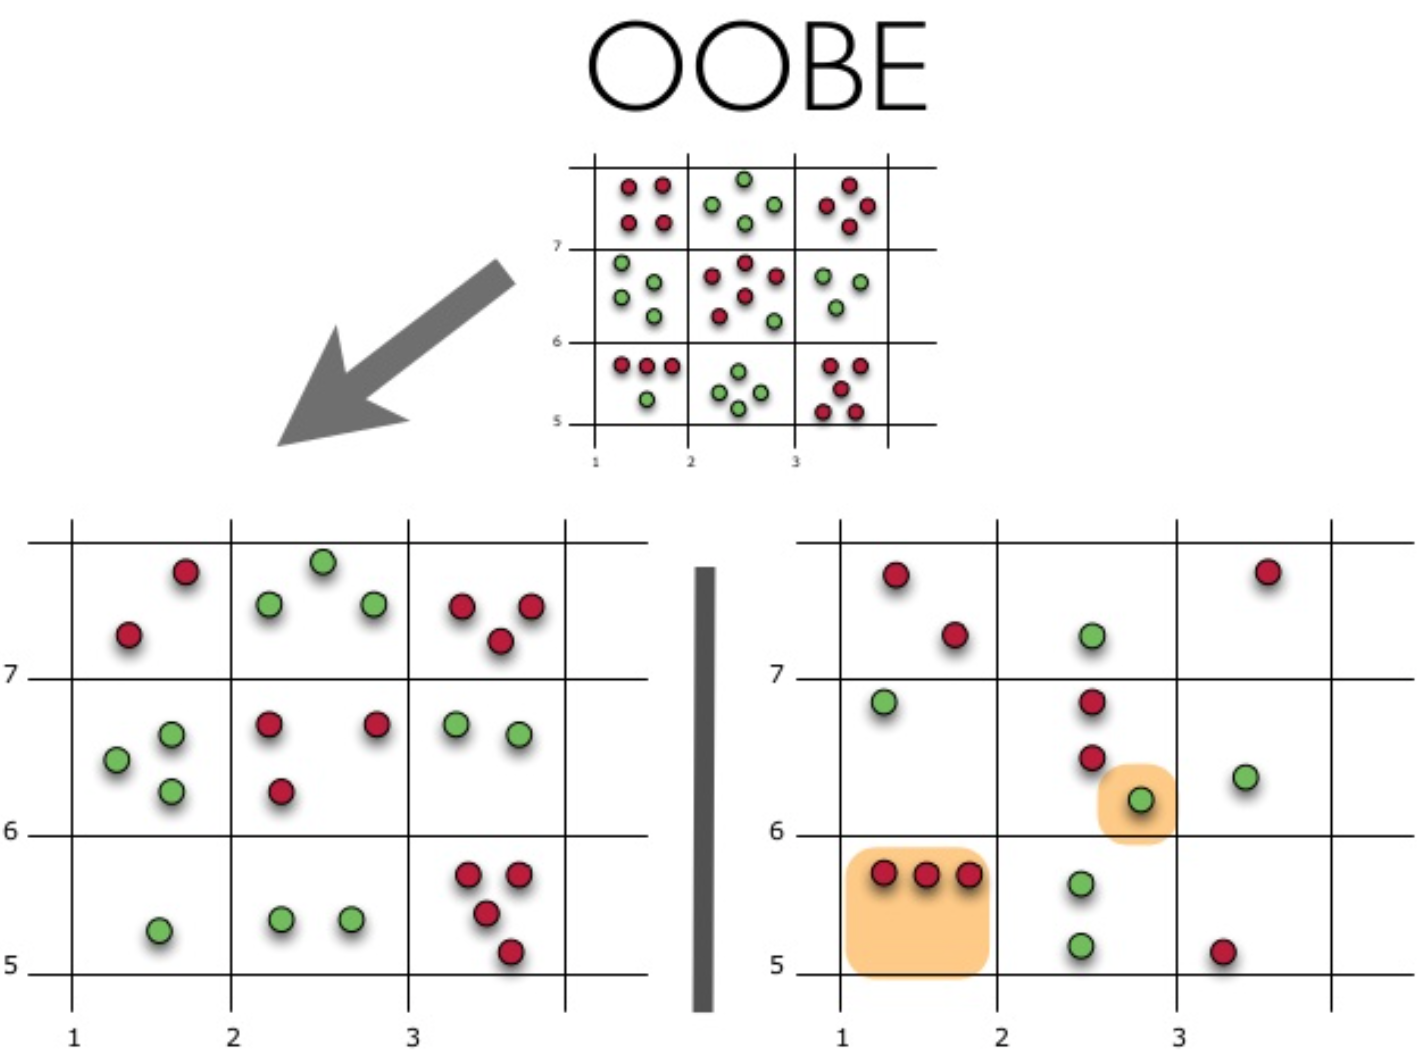

In [11]:
Image('images/oob.png',width=400)

На рисунке видно, что наш классификатор ошибся в 4 наблюдениях, которые мы не использовали для тренировки. Значит точность нашего классификатора: $\frac{11}{15}*100\% = 73.33\%$

Получается, что каждый базовый алгоритм обучается на ~63% исходных объектов. Значит, на оставшихся ~37% его можно сразу проверять. Out-of-Bag оценка — это усредненная оценка базовых алгоритмов на тех ~37% данных, на которых они не обучались.

In [12]:
X, y = make_regression(n_samples=1000, n_features=100, n_informative=100, n_targets=1, shuffle=False)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)


In [13]:
br = BaggingRegressor(estimator=DTR(),
                      n_estimators=200,
                      oob_score=True #включим использование oob
                     ).fit(X_train, y_train)
br.oob_score_ #ошибка на oob объектах

0.23616238491244357

# 4. Random Subspace Method (RSM)

Еще одна интересная эвристика: обучать алгоритмы не на всех фичах. Выберем (без повторений конечно же) некоторое число фич рандомно и на них будем обучаться

In [14]:
X, y = make_regression(n_samples=1000, n_features=100, n_informative=100, n_targets=1, shuffle=False)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)


In [15]:
def find_error(max_features_float):
    br = BaggingRegressor(estimator=DTR(max_features=max_features_float), #выбрали процент используемых фич
                          n_estimators=200,
                          max_features=0.33,
                          bootstrap_features=True).fit(X_train, y_train)
    return MSE(br.predict(X_test), y_test)



In [16]:
%%time
feature_percent = np.linspace(0.1, 1, 10)

errors = np.array([find_error(i) for i in feature_percent])

CPU times: user 13.1 s, sys: 12.1 ms, total: 13.1 s
Wall time: 13.1 s


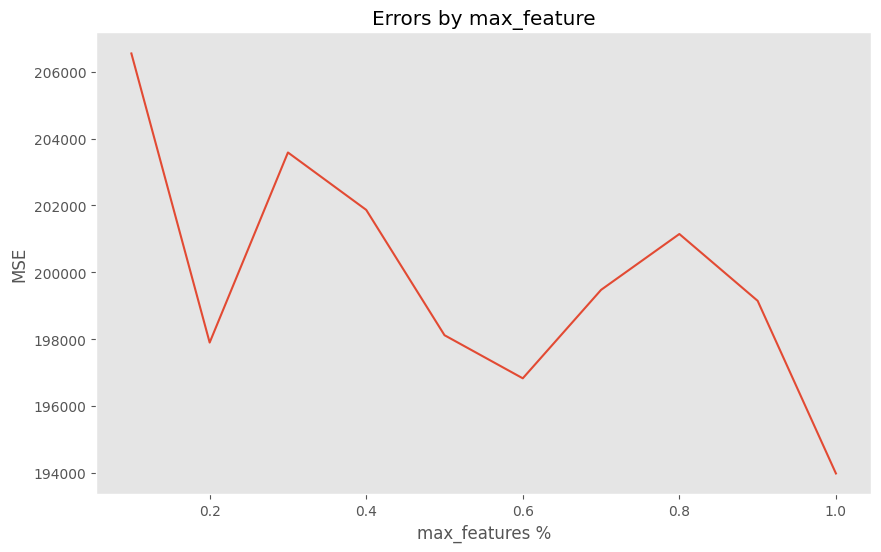

In [17]:
import matplotlib.pyplot as plt

plt.plot(feature_percent,errors)
plt.title('Errors by max_feature')
plt.ylabel('MSE')
plt.xlabel('max_features %')
plt.grid()

Я честно пытался разобраться как работает эта эвристика, но ничего не вышло.
Утвеждается, что:
* Для регрессии желательно использовать $k = n_{features}/3$ (max_features=0.33)
* Для классификации желательно использовать $k = \sqrt{(n_{features})}$ (max_features="sqrt")

# 5. RandomForest

![xkcd](https://imgs.xkcd.com/comics/in_the_trees.jpg)

**Идея**: совместим Bagging и RSM на DecisionTree.

Почему деревья? 

Бэггинг уменьшает $Variance$, но не можем никак повлиять на $Bias$. Значит нам нужно взять алгоритм, который может достигать минимального $Bias$. Деревья - отличный вариант, так как могут в том числе переобучиться и просто полностью запомнить выборку.

А метод случайных подпространств позволяет снизить коррелированность между деревьями и избежать переобучения. 

### Алгоритм

Алгоритм построения случайного леса, состоящего из $N$ деревьев, выглядит следующим образом:
* Для каждого $n = 1, \dots, N$:
     * Сгенерировать выборку $X_n$ с помощью bootstrap.
     * Построить решающее дерево $a_n$ по выборке $X_n$:
         — по заданному критерию мы выбираем лучший признак, делаем разбиение в дереве по нему и так до исчерпания выборки
         — дерево строится, пока в каждом листе не более $n_\text{min}$ объектов или пока не достигнем определенной высоты дерева
         — при каждом разбиении сначала выбирается $m$ случайных признаков из $n$ исходных, 
         и оптимальное разделение выборки ищется только среди них.
         
Итоговый классификатор $a(x) = \frac{1}{N}\sum_{i = 1}^N a_i(x)$, простыми словами — для задачи кассификации мы выбираем решение голосованием по большинству, а в задаче регрессии — средним.

Рекомендуется в задачах классификации брать $m = \sqrt{n}$, а в задачах регрессии — $m = \frac{n}{3}$, где $n$ — число признаков. Также рекомендуется в задачах классификации строить каждое дерево до тех пор, пока в каждом листе не окажется по одному объекту, а в задачах регрессии — пока в каждом листе не окажется по пять объектов.


<img src='images/rf.png' width=1200></img>

## Пример Регрессии (взят их курса ODS)

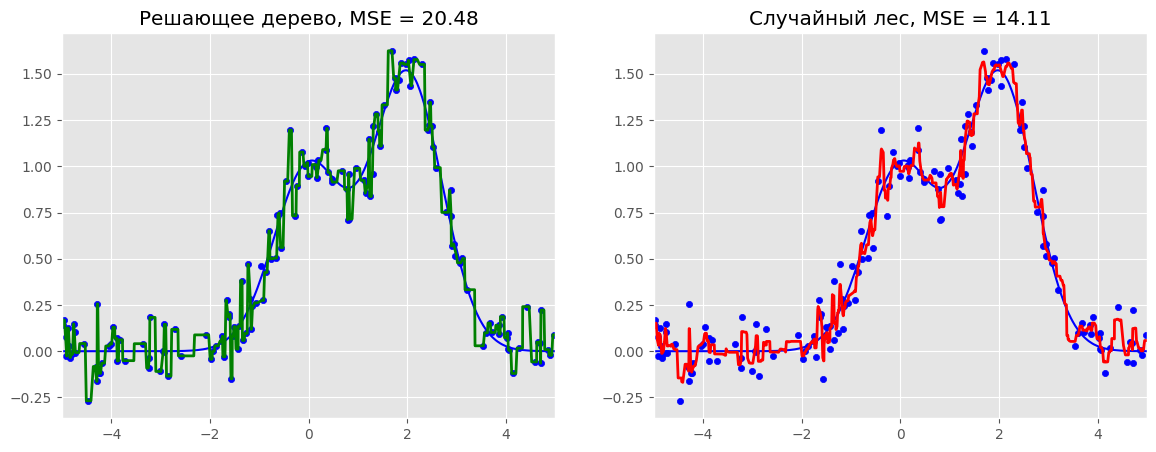

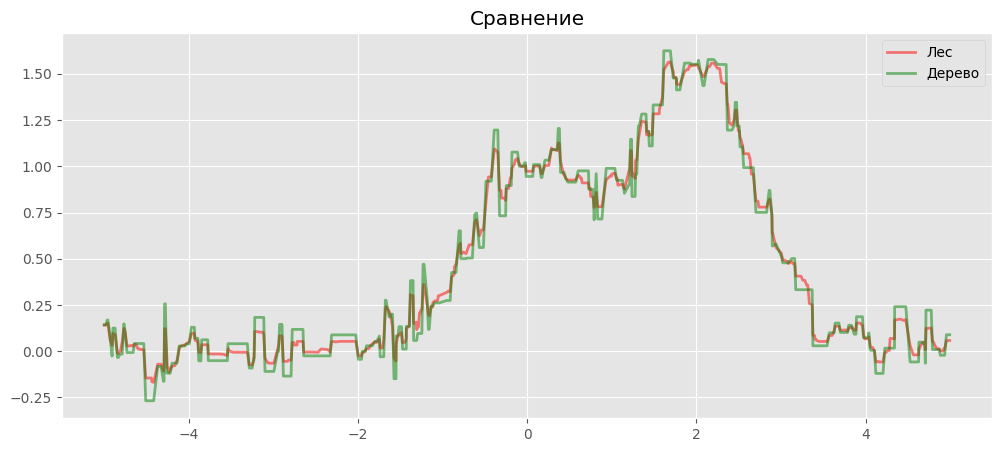

In [18]:
n_train = 150        
n_test = 1000       
noise = 0.1

# Generate data
def f(x):
    x = x.ravel()
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X).ravel()
    y = np.exp(-X ** 2) + 1.5 * np.exp(-(X - 2) ** 2)\
        + np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))

    return X, y

X_train, y_train = generate(n_samples=n_train, noise=noise)
X_test, y_test = generate(n_samples=n_test, noise=noise)

# One decision tree regressor
dtree = DecisionTreeRegressor().fit(X_train, y_train)
d_predict = dtree.predict(X_test)

fig, axes = plt.subplots(1,2, figsize=(14,5))

ax = axes[0]
ax.plot(X_test, f(X_test), "b")
ax.scatter(X_train, y_train, c="b", s=20)
ax.plot(X_test, d_predict, "g", lw=2)
ax.set_xlim([-5, 5])
ax.set_title("Решающее дерево, MSE = %.2f" 
          % np.sum((y_test - d_predict) ** 2))

# Random Forest
rf = RandomForestRegressor(n_estimators=50).fit(X_train, y_train)
rf_predict = rf.predict(X_test)
ax = axes[1]

ax.plot(X_test, f(X_test), "b")
ax.scatter(X_train, y_train, c="b", s=20)
ax.plot(X_test, rf_predict, "r", lw=2)
ax.set_xlim([-5, 5])
ax.set_title("Случайный лес, MSE = %.2f" % np.sum((y_test - rf_predict) ** 2))
plt.show()

plt.figure(figsize=(12,5))

ax = plt.gca()
ax.plot(X_test, rf_predict, "r", lw=2, label='Лес', alpha=.5)
ax.plot(X_test, d_predict, "g", lw=2, label='Дерево', alpha=.5)
ax.set_title("Сравнение")
ax.legend()
plt.show()

## Пример Классификации (взят из [курса ODS](https://mlcourse.ai/book/topic05/topic5_part2_random_forest.html))

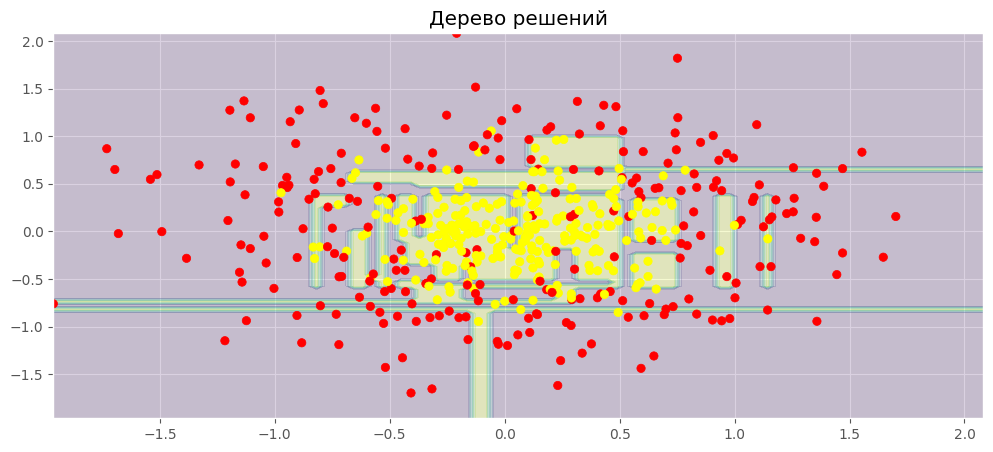

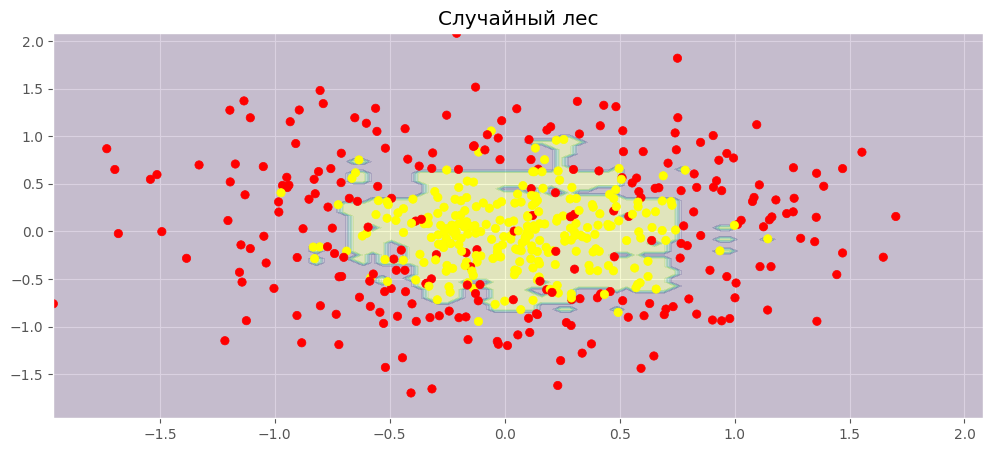

In [19]:
np.random.seed(42)
X, y = make_circles(n_samples=500, factor=0.1, noise=0.35, random_state=42)
X_train_circles, X_test_circles, y_train_circles, y_test_circles = train_test_split(X, y, test_size=0.2)

dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_train_circles, y_train_circles)

plt.figure(figsize=(12, 5))
x_range = np.linspace(X.min(), X.max(), 100)
xx1, xx2 = np.meshgrid(x_range, x_range)
y_hat = dtree.predict(np.c_[xx1.ravel(), xx2.ravel()])
y_hat = y_hat.reshape(xx1.shape)
plt.contourf(xx1, xx2, y_hat, alpha=0.2)
plt.scatter(X[:,0], X[:,1], c=y, cmap='autumn')
plt.title("Дерево решений")
plt.show()

rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train_circles, y_train_circles)
plt.figure(figsize=(12, 5))
x_range = np.linspace(X.min(), X.max(), 100)
xx1, xx2 = np.meshgrid(x_range, x_range)
y_hat = rf.predict(np.c_[xx1.ravel(), xx2.ravel()])
y_hat = y_hat.reshape(xx1.shape)
plt.contourf(xx1, xx2, y_hat, alpha=0.2)
plt.scatter(X[:,0], X[:,1], c=y, cmap='autumn')
plt.title("Случайный лес")
plt.show()

# 6. RF - идеальный алгоритм.(Нет)

Посмотрим, что происходит с произвольной задачей.

In [20]:
# Инициализируем задачу
X, y = make_classification(n_samples=10000, n_features=50, n_informative=40, shuffle=False, random_state=228)


In [21]:
# Инициализируем валидацию
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_acc, test_acc = [], []

# Обучаем на тренировочном датасете
trees_grid = [5, 10, 15, 20, 30, 50, 75, 100]
for ntrees in trees_grid:
    rfc = RandomForestClassifier(n_estimators=ntrees, random_state=42, n_jobs=-1, oob_score=True)
    temp_train_acc, temp_test_acc = [], []
    for train_index, test_index in skf.split(X, y):
        X_train, y_train, X_test, y_test = X[train_index,:],y[train_index], X[test_index, :], y[test_index]

        rfc.fit(X_train, y_train)
        
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} trees".format(max(test_acc.mean(axis=1))*100, 
                                                        trees_grid[np.argmax(test_acc.mean(axis=1))]))

Best accuracy on CV is 91.80% with 100 trees


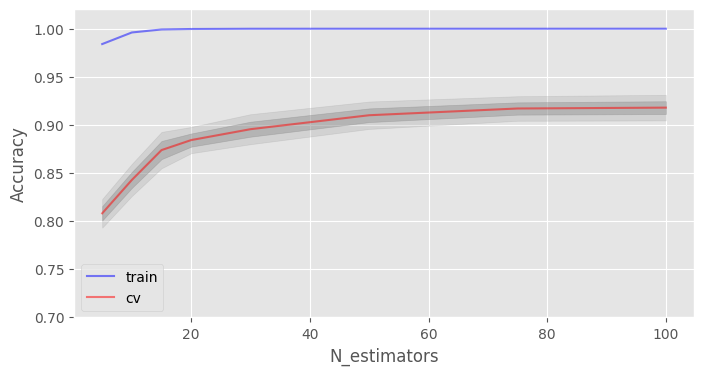

In [22]:
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(trees_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(trees_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(trees_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(trees_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.70,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("N_estimators");

Accuraсy стабильно растет при увеличении количества эстиматоров. Но можем ли мы достигнуть нуля? Нет.

Ошибка на тестовой выборке упрется в асимптоту. Почему? Вспомним формулу для Variance.

$$\mathbb{D}_{a}a(x)=\frac{1}{B}\sigma^2 + \frac{(B-1)}{B}\rho\sigma^2$$

При большом количестве деревьев первое слагаемое уйдет в ноль, но корреляция будет расти, так как появится много сильноскоррелированных деревьев, которые обучились на одинаковых выборках.

Можно ли как-то улучшить ситуацию и уменьшить корреляцию между деревьями?

## Попробуем стандартные способы регуляризации.

Чтобы уменьшить коррелированность между деревьями можно использовать стандартные методы регуляризации для деревьев:`max_depth`, `min_samples_leaf`, `max_features`

In [23]:
# Инициализируем валидацию
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_acc, test_acc = [], []
trees_grid = [5, 10, 15, 20, 30, 50, 75, 100]

# Обучаем на тренировочном датасете
for ntrees in trees_grid:
    rfc = RandomForestClassifier(n_estimators=ntrees, 
                                 random_state=42, 
                                 n_jobs=-1, 
                                 oob_score=True,
                                 max_features=4, # добавили
                                 max_depth=15, #немного
                                 min_samples_leaf=2) #регуляризации
    temp_train_acc, temp_test_acc = [], []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index,:], X[test_index, :]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} trees".format(max(test_acc.mean(axis=1))*100, 
                                                        trees_grid[np.argmax(test_acc.mean(axis=1))]))

Best accuracy on CV is 92.05% with 100 trees


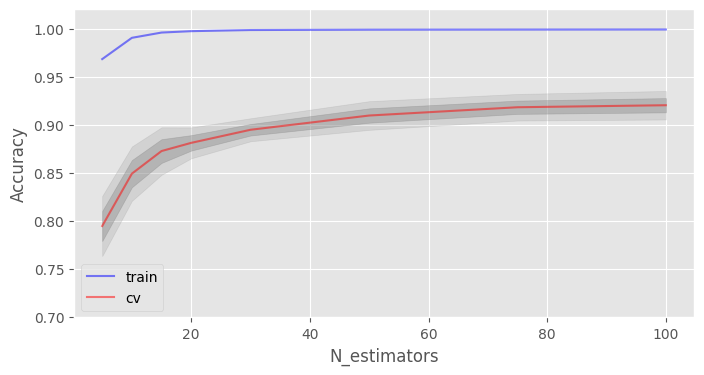

In [24]:
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(trees_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(trees_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(trees_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(trees_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.70,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("N_estimators");

Чуть чуть улучшили наш алгоритм. (Опять же пример игрушечный, в жизни также делаем GridSearch или RandomSearch) для наилучшего результата.

## Итог
* Нам нужно использовать переобученные деревья внутри RandomForest, чтобы минимизировать их Bias. 
* Нам нужно увеличивать количество деревьев, чтобы уменьшить слагаемое с чистой дисперсией
* При этом стараясь делать деревья как можно более `различными` за счет регуляризации.
* RF - переобучается за счет сильнокоррелированных деревьев, которые фактически запоминают выборку
* RF - неидеальный алгоритм, так как никуда от коррелированности деревьев не деться. Но в большинстве случаев это очень хороший алгоритм. 

# 7. Важность признаков.

Очень часто хочется понять алгоритм. Почему он работает именно так, а не иначе, почему дал определенный ответ. Или если не понять его полностью, то хотя бы какие переменные больше всего влияют на результат. Из случайного леса можно довольно просто получить данную информацию.

In [25]:
hostel_data = pd.read_csv("data/hostel_factors.csv")

In [26]:
n_features = 10
features = {
    "f1":u"Персонал",
    "f2":u"Бронирование хостела ",
    "f3":u"Заезд в хостел и выезд из хостела",
    "f4":u"Состояние комнаты",
    "f5":u"Состояние общей кухни",
    "f6":u"Состояние общего пространства",
    "f7":u"Дополнительные услуги",
    "f8":u"Общие условия и удобства",
    "f9":u"Цена/качество",
    "f10":u"ССЦ"
}

rf = RandomForestRegressor(n_estimators=100, max_features=n_features, random_state=0)
X = hostel_data.drop(['hostel', 'rating'], axis=1)
y = hostel_data['rating']
rf.fit(X, y)

RandomForestRegressor(max_features=10, random_state=0)

In [27]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_indices = [ind+1 for ind in indices[:n_features]]

print("Feature ranking:")  
for f in range(n_features):
    print("%d. %s %f " % (
        f + 1, 
        features["f"+str(feature_indices[f])], 
        importances[indices[f]])
    )

Feature ranking:
1. Персонал 0.210751 
2. Цена/качество 0.175066 
3. ССЦ 0.122167 
4. Состояние общего пространства 0.112113 
5. Дополнительные услуги 0.081404 
6. Общие условия и удобства 0.074633 
7. Заезд в хостел и выезд из хостела 0.072012 
8. Бронирование хостела  0.059564 
9. Состояние общей кухни 0.053865 
10. Состояние комнаты 0.038425 


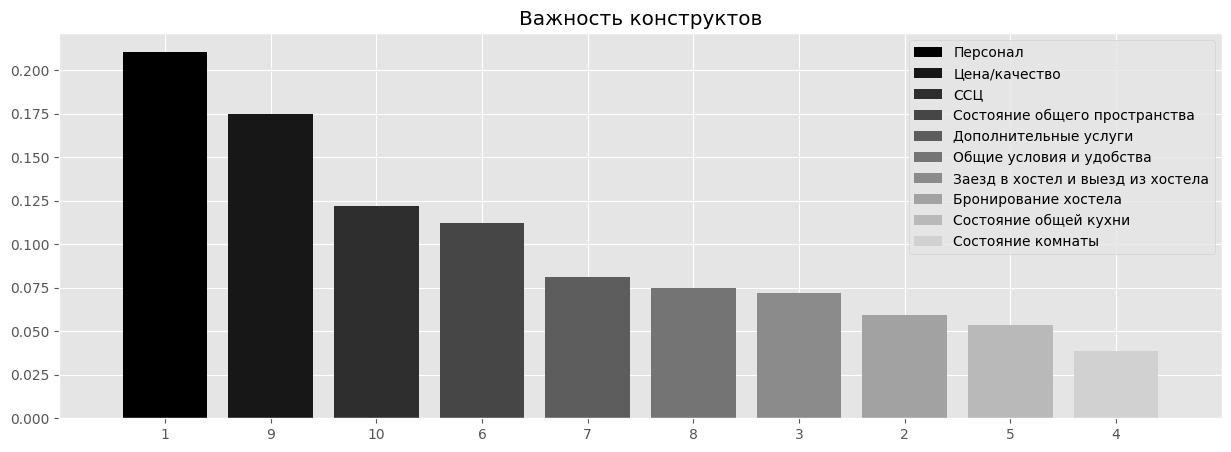

In [28]:
plt.figure(figsize=(15, 5))
plt.title(u"Важность конструктов")
bars = plt.bar(
    range(n_features), 
    importances[indices[:n_features]],
    color=([str(i/float(n_features + 1)) for i in range(n_features)])
)
ticks = plt.xticks(range(n_features), feature_indices)
plt.xlim([-1, n_features])
plt.legend(bars, [u''.join(features[f'f{i}']) for i in feature_indices])

На рисунке выше видно, что люди больше всего обращают внимание на персонал и соотношение цена/качество и на основе впечатления от данных вещей пишут свои отзывы. Но разница между этими признаками и менее влиятельными признаками не очень значительная, и выкидывание какого-то признака приведет к уменьшению точности нашей модели. Но даже на основе нашего анализа мы можем дать рекомендации отелям в первую очередь лучше готовить персонал и/или улучшить качество до заявленной цены.

# 8. Резюме

Мы рассмотрели такие концепции как:
* Boosting
* Bias-variance decomposition
* Bagging
* RandomForest

**RandomForest** - один из ключевых алгоритмов машинного обучения, который часто используется на практике, особенно, когда данных не очень много и нейронные сети не помогут.

## Повторим
* Нам нужно использовать переобученные деревья внутри RandomForest, чтобы минимизировать их Bias. 
* Нам нужно увеличивать количество деревьев, чтобы уменьшить слагаемое с чистой дисперсией
* При этом стараясь делать деревья как можно более `различными` за счет регуляризации.
* RF - переобучается за счет сильнокоррелированных деревьев, которые фактически запоминают выборку
* RF - неидеальный алгоритм, так как никуда от коррелированности деревьев не деться. Но в большинстве случаев это очень очень хороший алгоритм. 

**Плюсы**:
 - нечувствителен к масштабированию (и вообще к любым монотонным преобразованиям) значений признаков, связано с выбором случайных подпространств
 - не требует тщательной настройки параметров, хорошо работает «из коробки»
 - хорошо работает с пропущенными данными; сохраняет хорошую точность, если большая часть данных пропущенна
 - высокая параллелизуемость и масштабируемость.
 
**Минусы**:
 - в отличие от одного дерева, результаты случайного леса сложнее интерпретировать
 - алгоритм работает хуже многих линейных методов, когда в выборке очень много разреженных признаков (тексты, Bag of words)
 - алгоритм склонен к переобучению на некоторых задачах, особенно на зашумленных данных
 - больший размер получающихся моделей. Требуется $O(NK)$ памяти для хранения модели, где $K$ — число деревьев.

# Источники
* Bootstrap
* Bias-Variance
  * [Кратко и удобно](https://towardsdatascience.com/understanding-the-bias-variance-tradeoff-165e6942b229)
  * [Картинки, примеры кода, простое доказательство](http://rasbt.github.io/mlxtend/user_guide/evaluate/bias_variance_decomp/)
  * [Много полезных картинок](https://stanford.edu/~shervine/teaching/cs-229/cheatsheet-machine-learning-tips-and-tricks#classification-metrics)
  * [Полное доказательство, очень хорошая статья](https://www.cs.cmu.edu/~wcohen/10-601/bias-variance.pdf)
* Bagging
  * [ODS Лекция 5](https://habr.com/ru/company/ods/blog/324402/)
* RandomForest
  * 15 раздел книги “[Elements of Statistical Learning](https://web.stanford.edu/~hastie/Papers/ESLII.pdf)” Jerome H. Friedman, Robert Tibshirani, and Trevor Hastie
  * больше про практические применение случайного леса и других алгоритмов композиций в официальной документации [scikit-learn](http://scikit-learn.org/stable/modules/ensemble.html)